# ML4Earth Hackathon 2022
## Crop yield prediction with remote sensing and machine learning and exploring relations with explainable AI
#### Members:
*   Parinda Pannoon
*   Lisah Ligono
*   Yanika Dontong




#### Download files

! note: MODIS dates.xlsx is uploaded manually inside dataset/composite_npy

In [1]:
!wget https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/data/NPY/npy_corn_2003_2021.zip
!wget https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/data/NPY/npy_soybean_2003_2021.zip
!wget https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/geometry/Geometry.zip
!wget https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/yield/corn.csv
!wget https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/yield/soybean.csv
!wget https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/yield/winter_wheat.csv

--2022-11-27 04:08:50--  https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/data/NPY/npy_corn_2003_2021.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27240359 (26M) [application/x-zip-compressed]
Saving to: ‘npy_corn_2003_2021.zip’

npy_corn_2003_2021. 100%[===================>]  25.98M   593KB/s    in 46s     

2022-11-27 04:09:37 (578 KB/s) - ‘npy_corn_2003_2021.zip’ saved [27240359/27240359]

--2022-11-27 04:09:37--  https://syncandshare.lrz.de/dl/fiKnujzb9ZXoFGJ6j85Nmf/data/NPY/npy_soybean_2003_2021.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26714153 (25M) [application/x-zip-compressed]
Saving to: ‘npy_soybean_2003_2021.zip’

npy_so

In [2]:
!mkdir dataset
!mkdir dataset/composite_npy

In [3]:
!unzip 'npy_corn_2003_2021.zip' -d /content/dataset/composite_npy
!unzip 'npy_soybean_2003_2021.zip' -d /content/dataset/composite_npy
!unzip Geometry.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/composite_npy/soybean/2017_19069.npy  
  inflating: /content/dataset/composite_npy/soybean/2018_18053.npy  
  inflating: /content/dataset/composite_npy/soybean/2009_17161.npy  
  inflating: /content/dataset/composite_npy/soybean/2021_31079.npy  
  inflating: /content/dataset/composite_npy/soybean/2016_31081.npy  
  inflating: /content/dataset/composite_npy/soybean/2014_27135.npy  
  inflating: /content/dataset/composite_npy/soybean/2009_19153.npy  
  inflating: /content/dataset/composite_npy/soybean/2008_17051.npy  
  inflating: /content/dataset/composite_npy/soybean/2012_19079.npy  
  inflating: /content/dataset/composite_npy/soybean/2017_31133.npy  
  inflating: /content/dataset/composite_npy/soybean/2012_27013.npy  
  inflating: /content/dataset/composite_npy/soybean/2016_19005.npy  
  inflating: /content/dataset/composite_npy/soybean/2006_31175.npy  
  inflating: /content/dataset/composite_npy/soybean/

#### Read Npy files

In [4]:
import os, glob, re
import itertools
import pandas as pd
import numpy as np
import torch
from torch.utils import data
import json

MODIS_SCALE_FACTOR = 1e-4
MODIS_FEATURES_IDX = [i for i in range(0, 7)]

class YieldDataset(data.Dataset):
    
    def __init__(self, image_folder, label_path, crop_type, year, return_id=False):
        super(YieldDataset, self).__init__()

        self.image_folder = image_folder
        self.label_path = label_path
        self.crop_type = crop_type
        self.return_id = return_id

        # read images
        self.image_paths = glob.glob(self.image_folder +'/**/*.npy',  recursive=True)
        file_names = [x.split('/')[-1].replace('.npy', '') for x in self.image_paths]
        years = np.array([int(x[:4]) for x in file_names])
        geoids = np.array([x.split('_')[-1] for x in file_names])
        df_image = pd.DataFrame({'id':geoids, 'year':years})

        # read the labels
        with open(label_path) as f:
            yield_per_parcel = json.load(f)

        years, yields, ids = [], [], []
        for item in yield_per_parcel.items():
            years.append(int(item[0].split('_')[1]))
            ids.append(item[0].split('_')[0])
            yields.append(item[1])

        df_yield = pd.DataFrame({'id':ids, 'year':years, 'yield':yields})
        df_yield = df_yield[df_yield['year'] == year]
        # keep only intersection
        self.data = pd.merge(df_yield, df_image, how='inner')
        self.len = len(self.data.index)

    def __len__(self):
        return self.len

    def __getitem__(self, item):
        row = self.data.iloc[item]

        features = np.load(self.image_folder + '{}_{}.npy'.format(row['year'], row['id']))

        #scale the MODIS bands based on the scale provided in the data documentation
        for i in MODIS_FEATURES_IDX:
            features[:,i] = features[:,i] * MODIS_SCALE_FACTOR

        if self.return_id:
            return torch.from_numpy(features), torch.tensor(row['yield']), row['id']
        else:
            return torch.from_numpy(features), torch.tensor(row['yield'])


In [5]:
corn = YieldDataset('/content/dataset/composite_npy/corn/','/content/dataset/composite_npy/corn/labels.json',1,2003)

In [6]:
corn.data

,id,year,yield
0,17001,2003,171.0
1,17003,2003,147.0
2,17005,2003,131.0
3,17007,2003,152.0
4,17009,2003,168.0
...,...,...,...
386,31177,2003,118.6
387,31179,2003,142.3
388,31181,2003,133.2
389,31183,2003,164.3


In [7]:
corn[0]

(tensor([[ 1.4669e-01,  2.5981e-01,  7.5621e-02,  1.1514e-01,  3.5522e-01,
           3.6399e-01,  2.4139e-01, -4.9159e+00,  1.9465e+00,  3.3430e+00,
           0.0000e+00,  1.0000e+00,  2.8125e-01,  4.6925e-01, -1.5905e-01],
         [ 1.1590e-01,  1.9828e-01,  5.8589e-02,  8.9941e-02,  2.7766e-01,
           3.0232e-01,  2.2599e-01, -6.2309e+00,  3.6443e+00,  3.3250e-02,
           0.0000e+00,  1.0000e+00,  2.6169e-01,  4.3218e-01, -1.6930e-01],
         [ 6.5748e-01,  6.5945e-01,  6.2671e-01,  6.5303e-01,  4.1812e-01,
           1.6140e-01,  8.3759e-02, -1.2846e+01, -2.6209e+00,  6.9252e-01,
           0.0000e+00,  1.0000e+00,  3.0424e-02,  5.0738e-02,  1.9082e-01],
         [ 5.1535e-01,  5.3755e-01,  4.8716e-01,  5.0628e-01,  3.6608e-01,
           1.8144e-01,  1.0803e-01, -1.4992e+01, -4.4485e+00,  3.9439e-01,
           9.4582e-02,  2.0000e+00,  5.5914e-02,  9.0745e-02,  1.5406e-01],
         [ 1.2797e-01,  2.1443e-01,  6.5173e-02,  9.9514e-02,  2.9818e-01,
           3.1314e-01

#### Preprocessing Data

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import json

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns


In [181]:
ROOT_DATA_DIR = "dataset/composite_npy/"
COUNTY_FEATURE_NAMES = ["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2", "TEMP_MIN", "TEMP_MAX", "PRCP", "HEATWAVE INDEX", "DROUGHT INDEX", "NDVI", "EVI", "NDWI"]
NUM_FEATURES_PER_DATE = len(COUNTY_FEATURE_NAMES)

# "year" should be the integer year number (2000-2021)
# The function will return a list of required dates
def get_observation_acquisition_dates(year):
    # read a certain column before the 46th row
    df = pd.read_excel(io=os.path.join(ROOT_DATA_DIR, 'MODIS dates.xlsx'), usecols=[year - 2000], nrows=46)
    dates = df[year].values.tolist()
    return dates

def get_feature_names(dates):
    feature_names = []
    for date in dates:
        for county_feature in COUNTY_FEATURE_NAMES:
            feature_name = '{}_{}'.format(date, county_feature)
            feature_names.append(feature_name)
    
    return feature_names

def load_features_and_yield(crop,target_year):
    #read the crop yield values from the json file
    with open(os.path.join(ROOT_DATA_DIR+crop+'/labels.json')) as f: 
        crop_yield_per_county = json.load(f) 
    
    counties_features = []
    counties_yield = []
    counties_id_key = []
    #read the parcel features and the corresponding yields
    for county_features_file in os.listdir(ROOT_DATA_DIR+crop):
            if county_features_file.startswith(str(target_year)):
                county_id = county_features_file.split('.')[0].split('_')[1]
                county_id_key = '{}_{}'.format(county_id, target_year) 
                if county_id_key in crop_yield_per_county:
                    counties_id_key.append(county_id)
                    county_yield = float(crop_yield_per_county[county_id_key])
                    counties_yield.append(county_yield)
                    county_features_file_path = os.path.join(ROOT_DATA_DIR+crop+'/'+county_features_file)
                    county_features = np.load(county_features_file_path)
                    counties_features.append(county_features.flatten())
                    
    
    #scale all features in range [0, 1]
    counties_features = np.array(counties_features)
    scaler = MinMaxScaler()
    scaler.fit(counties_features)
    counties_features = scaler.transform(counties_features)
    
    #convert the features to pandas dataframe
    observation_acquisition_dates = get_observation_acquisition_dates(target_year)
    feature_names = get_feature_names(observation_acquisition_dates)
    counties_features = pd.DataFrame(counties_features, columns = feature_names)
    counties_features['county_id_key'] = counties_id_key
    counties_yield = np.array(counties_yield)
    return counties_features, counties_yield

def get_abs_feature_importance_over_time(feature_suffix, shap_values, feature_names):
    feature_indices = np.array([feature_names.index(feature) for feature in feature_names if feature.endswith(feature_suffix)])
    feature_dates = [feature_names[idx].split('_')[0] for idx in feature_indices]
    feature_importance_over_time = np.take(shap_values, feature_indices)

    feature_importance_over_time = pd.DataFrame(feature_importance_over_time, feature_dates)
    feature_importance_over_time["Feature"] = feature_suffix
    feature_importance_over_time = feature_importance_over_time.reset_index()
    feature_importance_over_time = feature_importance_over_time.set_axis(['Date','Permutation importance','Feature'],axis=1)
    feature_importance_over_time['Date'] =  pd.to_datetime(feature_importance_over_time['Date'], format='%Y%m%d')
    return feature_importance_over_time

def get_abs_features_importances_over_time(shap_values, feature_names):
    all_features_importances_over_time = []
    
    for feature_suffix in COUNTY_FEATURE_NAMES:
        all_features_importances_over_time.append(get_abs_feature_importance_over_time(feature_suffix, shap_values, feature_names))
    
    return pd.concat(all_features_importances_over_time)

In [137]:
# #load the dataset
counties_features, counties_yield = load_features_and_yield('corn',2003)
feature_names = counties_features.columns.values.tolist()

In [138]:
counties_features.head()

,20030101_RED,20030101_NIR,20030101_BLUE,20030101_GREEN,20030101_NIR2,20030101_SWIR1,20030101_SWIR2,20030101_TEMP_MIN,20030101_TEMP_MAX,20030101_PRCP,...,20031227_SWIR2,20031227_TEMP_MIN,20031227_TEMP_MAX,20031227_PRCP,20031227_HEATWAVE INDEX,20031227_DROUGHT INDEX,20031227_NDVI,20031227_EVI,20031227_NDWI,county_id_key
0,0.018605,0.150139,0.005622,0.016483,0.316955,0.448997,0.325633,0.936600,0.667767,0.988659,...,0.303521,0.992220,0.990959,0.700255,0.0,0.00,0.916836,0.905260,0.203280,17151
1,0.017122,0.087652,0.009498,0.012267,0.204189,0.400998,0.305396,0.882022,0.586186,0.590872,...,0.358945,0.925116,0.959296,0.406146,0.0,0.00,0.780387,0.744548,0.145506,17165
2,0.005642,0.109589,0.000428,0.002199,0.245223,0.386665,0.283037,0.927178,0.611135,0.826099,...,0.331515,0.934048,0.885697,0.406534,0.0,0.00,0.879295,0.854579,0.174109,18101
3,0.069652,0.112997,0.031000,0.038047,0.380743,0.746962,0.714260,0.279964,0.555990,0.000000,...,0.641312,0.536050,0.684120,0.000000,0.0,0.75,0.529081,0.473763,0.104774,19137
4,0.039883,0.083016,0.018087,0.016686,0.328387,0.679915,0.651249,0.352809,0.503874,0.000000,...,0.714626,0.581920,0.652908,0.000000,0.0,0.50,0.700393,0.651790,0.091254,19053


In [204]:
counties_yield[0:5]

array([67.4, 54.8, 58.7, 53.8, 64.8])

In [21]:
!mkdir images
!mkdir images/top_importance
!mkdir images/time_series_imp

#### Train Model & Evaluate

In [192]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
top_importance_path = 'images/top_importance/'
time_series_path = 'images/time_series_imp/'

def train_model(counties_features,counties_yield,crop,year):
    #train and test the random forest model based on the data acquired in 2021
    counties_features_train, counties_features_test, counties_yield_train, counties_yield_test = train_test_split(counties_features, counties_yield, test_size=0.2, random_state=42)
    # random_forest_regressor = RandomForestRegressor(n_estimators=50)
    svr_rbf  = svm.SVR()
    svr_rbf.fit(counties_features_train.iloc[:,:-1], counties_yield_train)
    r2_score = svr_rbf.score(counties_features_test.iloc[:,:-1], counties_yield_test)
    print("R^2 score in the test set is %0.2f" % (r2_score))
    y_pred = svr_rbf.predict(counties_features_test.iloc[:,:-1])
    yield_result = pd.DataFrame({"county_id_key":counties_features_test.iloc[:,-1],"actual yield": counties_yield_test,"predicted yield":y_pred})
    yield_result.to_csv('yield_'+crop+'_'+str(year)+'.csv')

    # perform permutation importance
    results = permutation_importance(svr_rbf, counties_features_train.iloc[:,:-1], counties_yield_train, scoring='r2')
    # get importance
    importance = results.importances_mean
    # summarize feature importance
    importance_df = pd.DataFrame(importance)
    importance_df = importance_df.set_index(counties_features.iloc[:,:-1].columns).reset_index().set_axis(["Feature","Importance"],axis=1)
    importance_df["abs_imp"] = importance_df['Importance'].abs()
    importance_df = importance_df.sort_values(by=['abs_imp'],ascending=False)
    plt.bar([x for x in importance_df["Feature"][:20]], importance_df["Importance"][:20])
    plt.xticks(rotation = 90)
    plt.savefig(top_importance_path+crop+'_'+str(year)+'_top20.png')
    plt.show()
    return results

In [140]:
def plot_permutation_important(results,crop,year):
    abs_features_importances_over_time = get_abs_features_importances_over_time(results.importances_mean, feature_names)
    g = sns.relplot(
        data=abs_features_importances_over_time,
        x="Date", y="Permutation importance",
        col="Feature",kind="line",
        ci="sd", col_order=["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2", "NDVI", "EVI", "NDWI", "TEMP_MIN", "TEMP_MAX", "PRCP", "HEATWAVE INDEX", "DROUGHT INDEX"],
        col_wrap=5, height=5, aspect=1)

R^2 score in the test set is 0.25


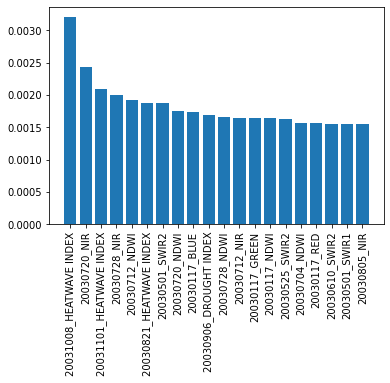

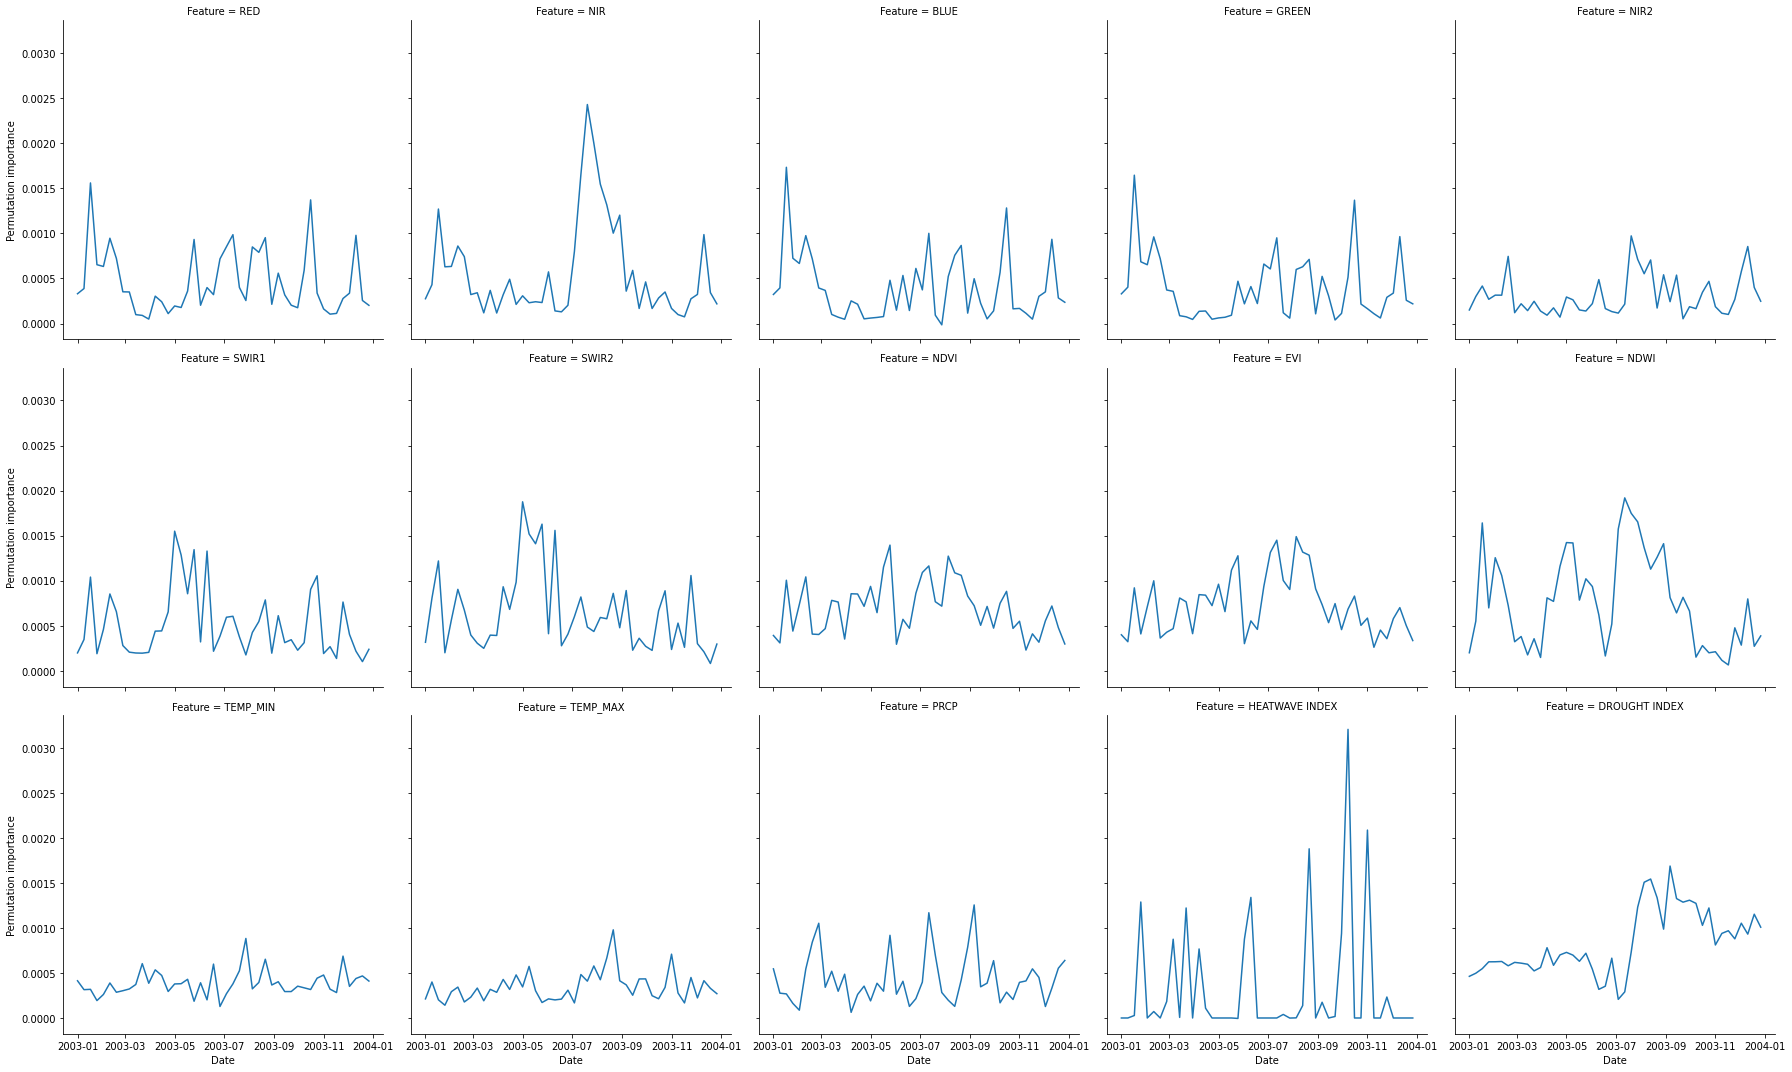

In [200]:
# years = [2003,2006,2020]
# for year in years:
counties_features, counties_yield = load_features_and_yield('corn',2003)
feature_names = counties_features.columns.values.tolist()
results = train_model(counties_features,counties_yield,'corn',2003)
plot_permutation_important(results,'corn',2003)

In [203]:
for crop in ['corn','soybean']:
    for year in [2003,2006,2020]:
        counties_features, counties_yield = load_features_and_yield(crop,year)
        feature_names = counties_features.columns.values.tolist()
        #train and test the random forest model based on the data acquired in 2021
        counties_features_train, counties_features_test, counties_yield_train, counties_yield_test = train_test_split(counties_features, counties_yield, test_size=0.2, random_state=42)
        # random_forest_regressor = RandomForestRegressor(n_estimators=50)
        svr_rbf  = svm.SVR()
        svr_rbf.fit(counties_features_train.iloc[:,:-1], counties_yield_train)
        r2_score = svr_rbf.score(counties_features_test.iloc[:,:-1], counties_yield_test)
        print(crop,year,"R^2 score in the test set is",r2_score)

corn 2003 R^2 score in the test set is 0.25253870453304084
corn 2006 R^2 score in the test set is 0.27961125361788564
corn 2020 R^2 score in the test set is 0.2586425886429482
soybean 2003 R^2 score in the test set is 0.6180491416464733
soybean 2006 R^2 score in the test set is 0.6351032043874076
soybean 2020 R^2 score in the test set is 0.6032778870139556
